In [1]:
import getpass
import os

def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"please provide your {var}")

_set_if_undefined("OPENAI_API_KEY")

In [2]:
from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    ToolMessage,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langgraph.graph import END, StateGraph, START
from langchain.agents import AgentExecutor, create_openai_tools_agent
from langchain_openai import ChatOpenAI
from typing import Annotated

In [3]:
from templates import *
from langchain_experimental.tools import PythonREPLTool

In [4]:
python_repl_tool = PythonREPLTool()

In [5]:
def create_agent(llm: ChatOpenAI, tools: list, system_prompt: str):
    """Creating an Agent"""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name='messages'),
            MessagesPlaceholder(variable_name='agent_scratchpad')
        ]
    )
    agent = create_openai_tools_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools)
    return executor

In [6]:
def agent_node(state, agent, name, log):
    result = agent.invoke(state)
    log[name] = result['output']
    return {"messages": [HumanMessage(content=result['output'], name=name)]}

In [7]:
from langchain_core.output_parsers.openai_functions import JsonOutputFunctionsParser

members = ["Extractor", "Validator", "Generator"]
system_prompt = (
    "你是一名监督员，负责管理以下成员之间的对话：{members}。"
    "根据以下用户请求，指定下一个需要行动的成员。每个成员将执行一个任务,"
    "你的任务是安排Extractor, Validator, 和Generator之间的工作，让他们合作教学视频中提取出完整题目及老师解析"
    "按照Extractor-Validator-Generator的顺序工作，Extractor进行初筛，Validator对于Extractor提取的每一道题进行评价，Generator根据Validator对于题目的评价决定是否保留当前题目，并输出最终满足要求的题目"
    "每一步反馈他们的结果和状态。任务完成后，请回复“FINISH”。"
)

options = ["FINISH"] + members

function_def = {
    "name": "route",
    "description": "选择下一步该由谁来执行",
    "parameters": {
        "title": "routeSchema",
        "type": "object",
        "properties": {
            "next": {
                "title": "Next",
                "anyOf": [
                    {"enum": options},
                ],
            }
        },
        "required": ['next']
    }
}

In [8]:
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name='messages'),
        (
            "system",
            "请根据Extractor-Validator-Generator，的顺序选择下一个执行的人"
            "当Generator执行完，输出“FINISH” "
            "请从以下选项中选一个：{options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))

llm = ChatOpenAI(model="gpt-4o", max_tokens=2000)

supervisor_chain = (
    prompt
    | llm.bind_functions(functions=[function_def], function_call="route")
    | JsonOutputFunctionsParser()
)

In [9]:
import functools
import operator
from typing import Sequence, TypedDict, Annotated

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    next: str
log = {}

extractor_agent = create_agent(llm, [python_repl_tool], extract_template)
extractor_node = functools.partial(agent_node, agent=extractor_agent, name='Extractor', log=log)

validator_agent = create_agent(llm, [python_repl_tool], validator_template)
validator_node = functools.partial(agent_node, agent=validator_agent, name="Validator", log=log)

generator_agent = create_agent(llm, [python_repl_tool], generator_template)
generator_node = functools.partial(agent_node, agent=generator_agent, name="Generator", log=log)


def supervisor_node(state, log):
    result = supervisor_chain.invoke(state)
    log["Supervisor"] = result
    return result

workflow = StateGraph(AgentState)
workflow.add_node("Extractor", extractor_node)
workflow.add_node("Validator", validator_node)
workflow.add_node("Generator", generator_node)
workflow.add_node("Supervisor", functools.partial(supervisor_node, log=log))

In [10]:
for member in members:
    if member == "Generator": continue
    workflow.add_edge(member, "Supervisor")

conditional_map = {k:k for k in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges("Supervisor", lambda x : x['next'], conditional_map)
workflow.add_edge(START, "Supervisor")
workflow.add_edge("Generator", END)
graph = workflow.compile()

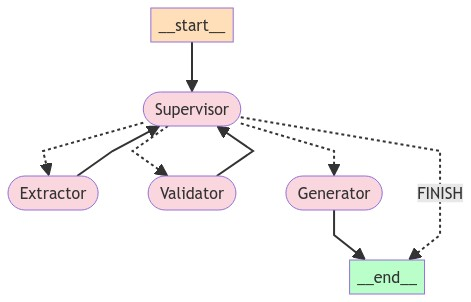

In [11]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    pass

In [12]:
import json
with open("grade_7x_subtitle.json", 'r') as f:
    data = json.load(f)
data[5]

'同学们大家好首先让我们先来了解本节课的学习目标主要包括一巩固平行线的判定方法二会用判定方法判断两条直线是否平行并解决较复杂的问题三学会写几何推理过程让我们先来回顾一下学过的知识大家想一想判定两条直线平行的方法有哪些我们在平行线这一节学习过可以用平行线的定义或平行公理的推论来判断两条直线是否平行但是这两种方法有一定的局限性上节课我们又重点研究了平行线的这三种判定方法可以通过同位角相等或者内错角相等或者同旁内角互补来判断两条直线是否平行这三种判定方法也是本章的重点之一今天我们将通过几道例题继续研究这三种判定方法让我们先来看看第一道例题如图当角一等于角二时求证ab平行于CD如何证明呢请大家按下暂停键先认真思考一下相信很多同学都已经想到了证明方法要判断ab与CD是否平行只需要看角一和角三这对同位角是否相等已知条件告诉我们角一等于角二而角二和角三又是一对对顶角这样我们可以很容易地得出角一和角三相等从而证明出ab平行于CD证明过程可以这样书写因为角一等于角二已知又因为角二等于角三对顶角相等所以角一等于角三所以ab平行于CD同位角相等两直线平行当然这道题的方法并不唯一我们也可以证明角二和角四这对同位角相等或者角三和角四这对内错角相等或者角三和角五相加等于180度由同旁内角互补证明出ab平行于CD希望同学们可以熟练掌握这三种判定方法让我们来继续看例二在同一平面内如果两条直线都垂直于同一条直线那么这两条直线平行吗这道题和例一有一个明显的区别这是一道文字证明题所以我们先把这些文字转化成我们熟悉的几何语言包括符号语言和图形语言我们想证明如果B垂直于AC垂直于A那么B平行于C吗请同学们按下暂停键先认真思考一下我们先标出这道题可能会用到的角要证明B是否平行于C我们只需要证明角一和角二这对同位角是否相等或者角一和角三这对内错角是否相等或者角一和角四这对同旁内角是否互补我们知道垂直总是能和直角联系在一起所以有已知的B垂直于AC垂直于A可以得到角一角二角三角四都是90度从而这三种思路都是可行的我们选取第一种思路写出证明过程因为B垂直于AC垂直于A已知所以角一等于角二等于90度垂直的定义所以B平行于C同位角相等两直线平行这道题可以得到我们初中阶段一个重要的结论垂直于同一条直线的两条直线平行这个结论我们以后也会常常用到希望同学们能牢牢记住同学们的前两道例题掌握的怎么样让我们继续看例三如图已知角一和角

In [13]:
len(data)

43

In [17]:
record = []
for i in range(len(data)):
    if i in range(0,12) or i in range(19,22) or i in range(39, 43):
        continue
    try:
        for s in graph.stream(
            {
                "messages": [
                    HumanMessage(content=data[i])
                ]
            }
        ):
            if "__end__" not in s:
                record.append(s)
                print(s)
                print("----")
    except Exception as e:
        print(f"Encountered {e}")
        continue

{'Supervisor': {'next': 'Extractor'}}
----
{'Extractor': {'messages': [HumanMessage(content='### 原题一：\n学校要举行庆国庆美术作品比赛，小东想裁出一块面积为25平方分米的正方形画布，画上自己的得意之作参加比赛。那么这块正方形画布的边长应该取多少呢？\n\n### 讲解一：\n这个问题非常简单，同学们容易想出来。要求这块正方形画布的边长，也就是要求一个正数使得它的平方等于25。我们很容易想到五的平方等于25，所以这个正方形画布的边长应该取五分米。\n\n### 原题二：\n小东还要准备一些面积如下的正方形画布，请你帮他把这些正方形的边长都算出来。看到这些数字相信大家都不陌生，很容易得出相应的正方形的边长分别为1、3、4、6。那如果正方形的面积为4/25呢？\n\n### 讲解二：\n这个问题也难不倒大家，此时正方形的边长为2/5。\n\n### 原题三：\n求下列各数的算术平方根：\n1. 100\n2. \\( \\frac{49}{64} \\)\n3. 0.0001\n\n### 讲解三：\n我们说要说出这几个数的算术平方根呢，应该说是比较简单的，但是呢我们还是要有严格的规范的书写过程。我们一起来看一下：\n\n1. 因为十的平方等于100，所以100的算术平方根为十，也就是 \\( \\sqrt{100} = 10 \\)。\n2. 因为 \\( \\left(\\frac{7}{8}\\right)^2 = \\frac{49}{64} \\)，所以 \\( \\frac{49}{64} \\) 的算术平方根是 \\( \\frac{7}{8} \\)，即 \\( \\sqrt{\\frac{49}{64}} = \\frac{7}{8} \\)。\n3. 因为 \\( 0.01^2 = 0.0001 \\)，所以 0.0001 的算术平方根为 0.01，也就是 \\( \\sqrt{0.0001} = 0.01 \\)。\n\n### 原题四：\n求 \\( \\sqrt{2^2} \\)、\\( \\sqrt{3^2} \\)、\\( \\sqrt{5^2} \\)、\\( \\sqrt{6^2} \\)、\\( \\sqrt{7^2} \\)、\\( \

In [18]:
import re
problem_set = []
for item in record:
    for role in item:
        if role == "Supervisor" or role == "Validator": continue
        if role == "Generator":
            final_extract = item[role]['messages'][0].content
            pattern = re.compile(r'### 原题.*?：\n(.*?)\n\n### 讲解.*?：\n(.*?)(?=\n###|$)', re.DOTALL)
            matches = pattern.findall(final_extract)

            for match in matches:
                ps_each = {}
                ps_each["problem"] = match[0].strip()
                ps_each["answer"] = match[1].strip()
                problem_set.append(ps_each)
                print(f"原题:\n{match[0].strip()}\n")
                print(f"讲解:\n{match[1].strip()}\n")
                print("\n\n\n\n")

原题:
学校要举行庆国庆美术作品比赛，小东想裁出一块面积为25平方分米的正方形画布，画上自己的得意之作参加比赛。那么这块正方形画布的边长应该取多少呢？

讲解:
这个问题非常简单，同学们容易想出来。要求这块正方形画布的边长，也就是要求一个正数使得它的平方等于25。我们很容易想到五的平方等于25，所以这个正方形画布的边长应该取五分米。






原题:
小东还要准备一些面积如下的正方形画布，请你帮他把这些正方形的边长都算出来。看到这些数字相信大家都不陌生，很容易得出相应的正方形的边长分别为1、3、4、6。那如果正方形的面积为4/25呢？

讲解:
这个问题也难不倒大家，此时正方形的边长为2/5。






原题:
求下列各数的算术平方根：
1. 100
2. \( \frac{49}{64} \)
3. 0.0001

讲解:
我们说要说出这几个数的算术平方根呢，应该说是比较简单的，但是呢我们还是要有严格的规范的书写过程。我们一起来看一下：

1. 因为十的平方等于100，所以100的算术平方根为十，也就是 \( \sqrt{100} = 10 \)。
2. 因为 \( \left(\frac{7}{8}\right)^2 = \frac{49}{64} \)，所以 \( \frac{49}{64} \) 的算术平方根是 \( \frac{7}{8} \)，即 \( \sqrt{\frac{49}{64}} = \frac{7}{8} \)。
3. 因为 \( 0.01^2 = 0.0001 \)，所以 0.0001 的算术平方根为 0.01，也就是 \( \sqrt{0.0001} = 0.01 \)。






原题:
求 \( \sqrt{2^2} \)、\( \sqrt{3^2} \)、\( \sqrt{5^2} \)、\( \sqrt{6^2} \)、\( \sqrt{7^2} \)、\( \sqrt{0^2} \) 的值，看看你有什么发现？

讲解:
我们发现它们还是有一些共同特征的。首先呢，它们都是含有根号，其次呢，被开方数都是某一个数的平方的形式。所以要想算出它们的值，首先需要把这个平方先计算出来，那么很容易知道：

1. \( \sqrt{2^2} = \sqrt{4} = 2 \)
2. \( \sqrt{3^2} = \sqrt{9} = 

In [19]:
with open("problem_set_g7.json", "w", encoding='utf-8') as f:
    json.dump(problem_set, f, ensure_ascii=False, indent=4)

In [20]:
len(problem_set)

103